# Neal's Funnel

In this experiment we consider *Neal's funnel* ([Neal (2003)](https://projecteuclid.org/journalArticle/Download?urlId=10.1214%2Faos%2F1056562461), Section 8), which is a simple toy example mean to showcase *funneling*, a pathological property inherent to many hierarchical probabilistic models. The target distribution $\nu$ is given by the unnormalized density

$$
\varrho_{\nu}(x)
= \mathcal{N}(x_1; 0,9) \prod_{i=2}^d \mathcal{N}(x_i; 0, \exp(x_1)) ,
\qquad x \in \mathbb{R}^d ,
$$

in dimension $d = 10$. Clearly, the conditional distribution of the variables $x_2,...,x_d$ given a fixed value of $x_1$ is just Gaussian. The overall distribution $\nu$, however, takes a highly non-Gaussian shape. Like a funnel, it is very narrow at one end (for negative values of $x_1$) but very wide at the other end (for positive values of $x_1$).

Observe that the first marginal of $\nu$ (i.e. the marginal corresponding to variable $x_1$) is simply $\mathcal{N}(0,9)$. This enables us to analyze samplers by how well they recover the correct marginal distribution: If we let them generate approximate samples for $\nu$ and then discard all but the first entry of each sample, we obtain approximate samples of the first marginal of $\nu$. By our explicit knowledge of this marginal distribution, we can measure how well these approximate samples recover features like its mean and variance. In order to excel at all of these tasks, a sampler must necessarily work well in both the narrow and the wide part of the funnel, and transition between them frequently enough as to not overrepresent one side (note that by our knowledge of the marginal we know in particular that its probability mass is distributed perfectly evenly between positive and negative values of $x_1$).

We define four separate target quantities: mean, standard deviation, 0.001-quantile and 0.999-quantile. We let each sampler estimate these quantities throughout its run (which for simplicity we only simulate afterwards) and track the progression of these estimates. Below, we plot the progressions, scaled by the sampler's computation time to make the comparison a bit fairer (as GPSS tends to have a higher computational cost per iteration than HRUSS and ESS, and NUTS an even higher one than GPSS). Furthermore, we plot traces and histograms of the marginal samples and even a trace of the sample radii (to illustrate how well the samplers managed to explore the wide part of the funnel, which stretches out so far that some sample radii in the hundreds are to be expected).

Overall, the experiment serves to highlight that GPSS can outperform many of its competitors when it comes to dealing with funneling, which suggests that it could have utility in sampling from distributions resulting from hierarchical models.

In [1]:
import timed_slice_sampling as tss
from time import time
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
NUTS = True # whether or not to run and analyze NUTS for this experiment
if NUTS:
    import pymc as pm

### Construct Target Density and Choose Target Quantities

In [3]:
d = 10
w = 5
path_prefix = "../plots/Neals_funnel_"
rtf = 1.0 # runtime factor (each sampler is awarded rtf minutes runtime)

In [4]:
def log_density(x):
    x = x.reshape(-1)
    return -(x[0]**2)/18 - (d-1)/2*x[0] - np.sum(x[1:]**2)/(2*np.exp(x[0]))

For the normalization factor, note
$$
\log(\textstyle \prod_{i=2}^d (\sigma^2)^{-1/2}) 
= \log((\sigma^2)^{-(d-1)/2})
= -(d-1)/2 \cdot \log(\sigma^2)
$$
and
$$
-(d-1)/2 \cdot \log(\exp(x_1))
= -(d-1)/2 \cdot x_1 .
$$

In [5]:
# set up equivalent target for NUTS sampler from pymc
if NUTS:
    nuts_model = pm.Model()
    with nuts_model:
        x1_ = pm.Normal("x_1", mu=0, sigma=3)
        xrest_ = pm.Normal("x_(2,...,d)", mu=0, sigma=pm.math.exp(x1_ / 2), shape=d-1)

In [6]:
x_0 = np.zeros(d)
x_0[0] = 2

In [7]:
# quantiles and correct values
q1 = 0.001 #0.0001
q2 = 0.999 #0.9999
v1 = sts.norm(0,3).ppf(q1)
v2 = sts.norm(0,3).ppf(q2)
print("abs of quantile: {}".format(v2))

abs of quantile: 9.27069691850344


In [8]:
def print_target_quantities(samples):
    print("Empirical mean of first marginal: {:.4f}".format(np.mean(samples[:,0])))
    print("Empirical standard deviation of first marginal: {:.3f}".format(np.std(samples[:,0])))
    print("Empirical {:.4f} quantile: {:.3f}".format(q1, np.quantile(samples[:,0], q1)))
    print("Empirical {:.4f} quantile: {:.3f}".format(q2, np.quantile(samples[:,0], q2)))

### Run the samplers

In [9]:
itnum_gpss = int(rtf * 4e5)
samples_gpss, times_gpss = tss.gibbsian_polar_ss(log_density, x_0, w, itnum_gpss)
print_target_quantities(samples_gpss)

Empirical mean of first marginal: 0.0362
Empirical standard deviation of first marginal: 2.965
Empirical 0.0010 quantile: -9.037
Empirical 0.9990 quantile: 9.529


In [10]:
itnum_hruss = int(rtf * 1e6)
samples_hruss, times_hruss = tss.hit_and_run_uniform_ss(log_density, x_0, w, itnum_hruss)
print_target_quantities(samples_hruss)

Empirical mean of first marginal: 0.0270
Empirical standard deviation of first marginal: 3.122
Empirical 0.0010 quantile: -7.813
Empirical 0.9990 quantile: 9.256


In [11]:
itnum_ess = int(rtf * 4e5)
var = np.concatenate([np.array([9.0]), 70*np.ones(d-1)])
log_likelihood = lambda x: -tss.log_prior_indep(var, x) + log_density(x)
samples_ess, times_ess = tss.elliptical_ss(var, log_likelihood, x_0, itnum_ess)
print_target_quantities(samples_ess)

Empirical mean of first marginal: 0.0880
Empirical standard deviation of first marginal: 2.680
Empirical 0.0010 quantile: -5.701
Empirical 0.9990 quantile: 7.257


In [12]:
if NUTS:
    itnum_nuts = int(rtf * 6e4)
    wall_nuts = -time() # variable to eventually store wall clock time taken by nuts
    samples_nuts_raw = pm.sample(
        model=nuts_model,
        draws=itnum_nuts,
        chains=1,
        tune=1000,
        compute_convergence_checks=False,
        return_inferencedata=False,
        idata_kwargs=dict(log_likelihood=False),
    )
    wall_nuts += time()
    samples_nuts = np.hstack([samples_nuts_raw["x_1"].reshape(-1,1), samples_nuts_raw["x_(2,...,d)"]])
    times_nuts = np.linspace(0,wall_nuts,itnum_nuts+1) # interpolation as approx of analysis done for other samplers

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x_1, x_(2,...,d)]


Sampling 1 chain for 1_000 tune and 60_000 draw iterations (1_000 + 60_000 draws total) took 80 seconds.


### Process Outputs, Conduct Convergence Analysis

In [13]:
snames = ["GPSS", "HRUSS", "ESS"]
times = [times_gpss, times_hruss, times_ess]
tmax = int(rtf * 60) # retroactive runtime budget in seconds
full_samples = [samples_gpss, samples_hruss, samples_ess]

In [14]:
if NUTS:
    snames += ["NUTS"]
    times += [times_nuts]
    full_samples += [samples_nuts]

In [15]:
nsam = len(snames)
total_its = [np.searchsorted(ts, tmax) for ts in times]
samples = [full_samples[i][:total_its[i]] for i in range(nsam)]
marginal_samples = mcu.get_margs_list(samples, 0)
radii = mcu.get_radii_list(samples)

In [16]:
for i in range(nsam):
    print("{}: {} samples".format(snames[i], total_its[i]))

GPSS: 339398 samples
HRUSS: 795440 samples
ESS: 294179 samples
NUTS: 44777 samples


In [17]:
default_cycler = plt.rcParams["axes.prop_cycle"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0, 0.9, nsam)))

In [18]:
nspots = 10 * tmax # number of spots in time at which convergence is to be assessed 
spots = np.linspace(tmax/nspots, tmax, nspots) # spots in time at which convergence is to be assessed

In [19]:
means = np.zeros((nsam, nspots))
stds = np.zeros((nsam, nspots))
q1s = np.zeros((nsam, nspots))
q2s = np.zeros((nsam, nspots))

In [20]:
for i in range(nsam):
    # binary search for number of iterations performed up to each spot
    its = np.searchsorted(times[i], spots)
    for j, it in enumerate(its):
        means[i,j] = np.mean(marginal_samples[i][:it])
        stds[i,j] = np.std(marginal_samples[i][:it])
        q1s[i,j] = np.quantile(marginal_samples[i][:it], q1)
        q2s[i,j] = np.quantile(marginal_samples[i][:it], q2)

### Plotting

In [21]:
def conv_plot(vals, gt_val, ylabel, filename, conv_figsize=(4.5,3), dpi=250):
    plt.figure(figsize=conv_figsize, dpi=dpi)
    plt.xlabel("time (s)")
    plt.ylabel(ylabel)
    for s in range(nsam):
        plt.plot(spots, vals[s])
    plt.plot([0,tmax], [gt_val,gt_val], color="black", linestyle="dashed", zorder=0)
    plt.legend(snames)
    pfs.wrapup(path_prefix + filename + ".png")

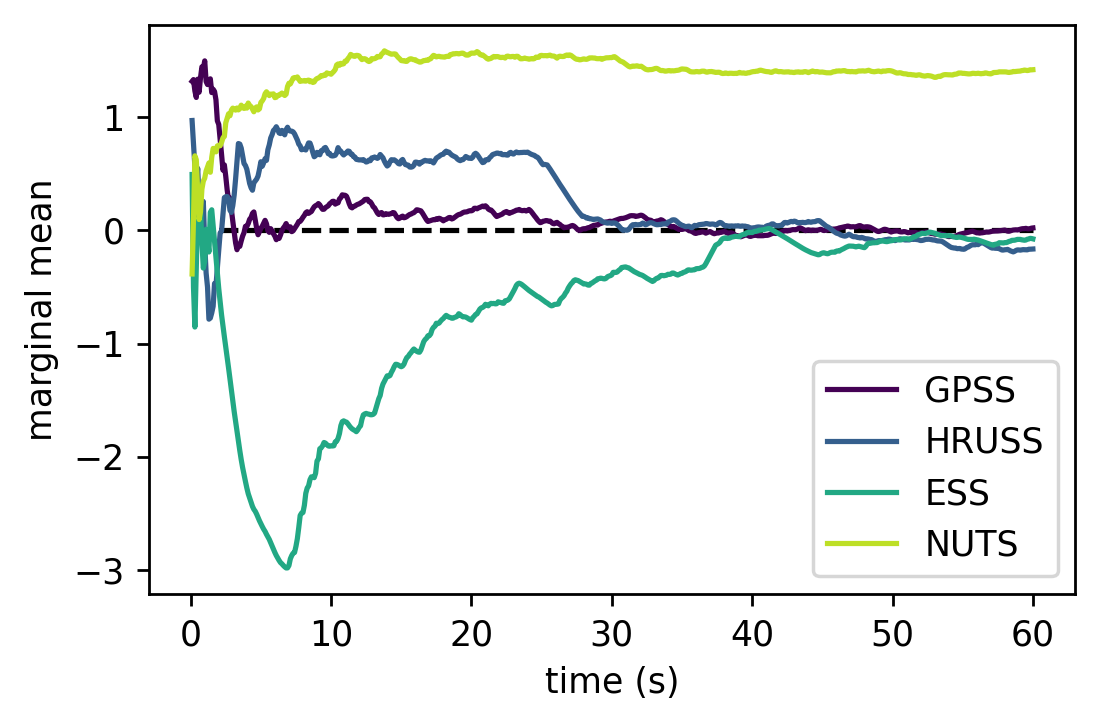

In [22]:
conv_plot(means, 0.0, "marginal mean", "mean_conv")

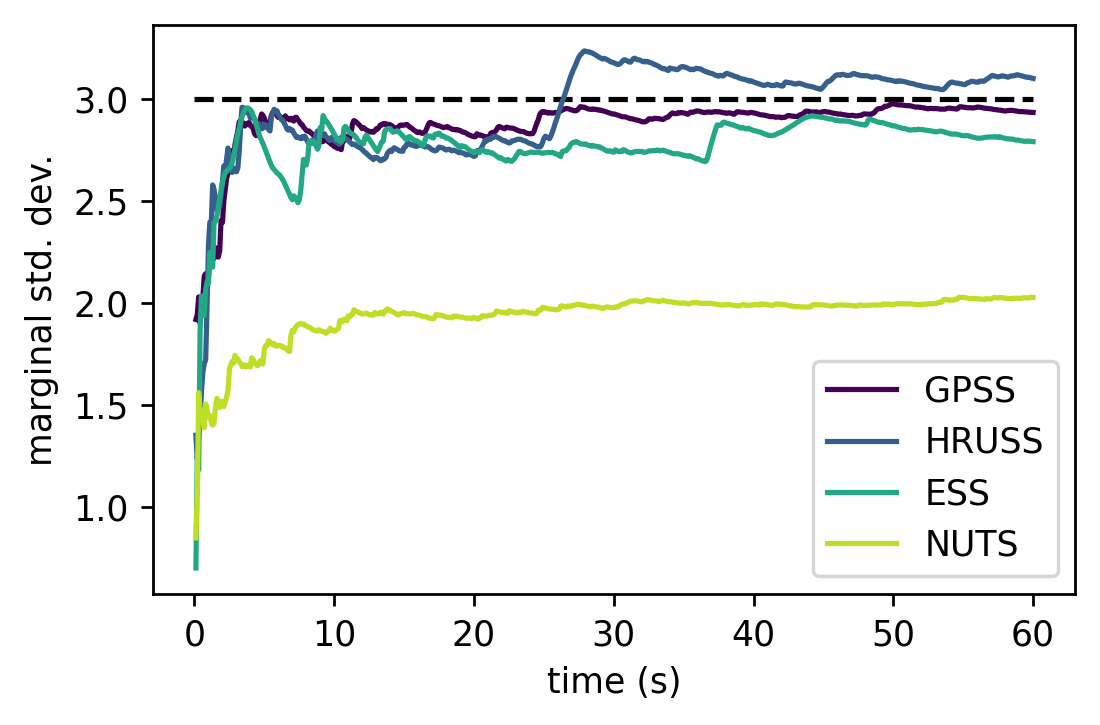

In [23]:
conv_plot(stds, 3.0, "marginal std. dev.", "std_conv")

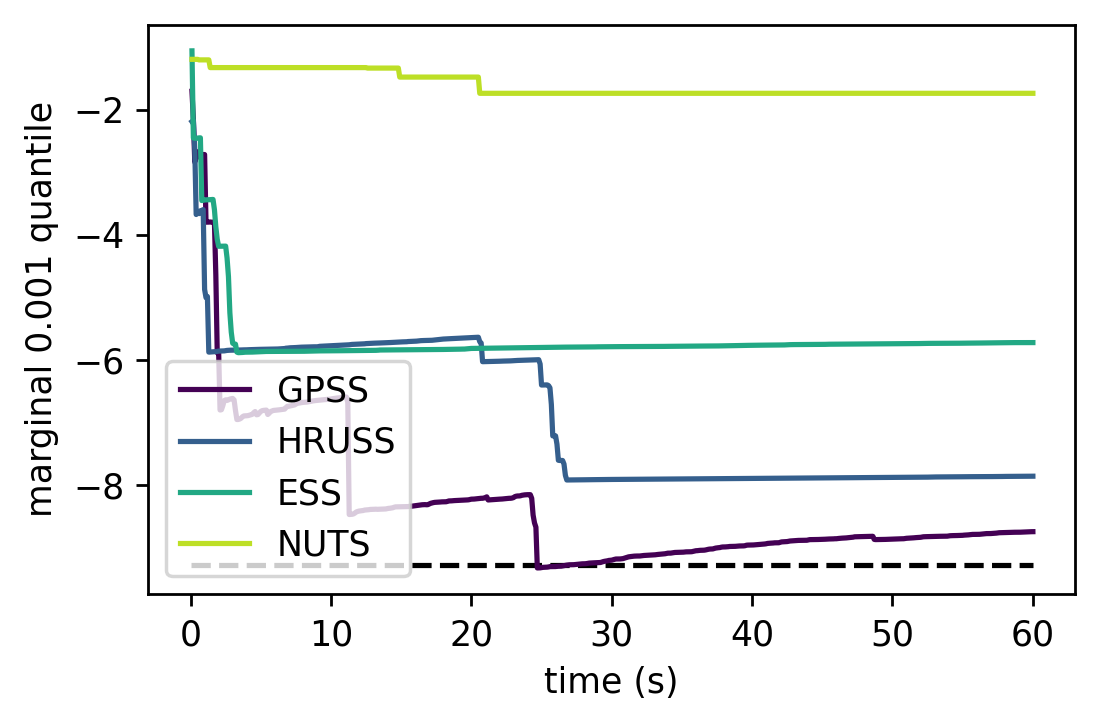

In [24]:
conv_plot(q1s, v1, "marginal {} quantile".format(q1), "q1_conv")

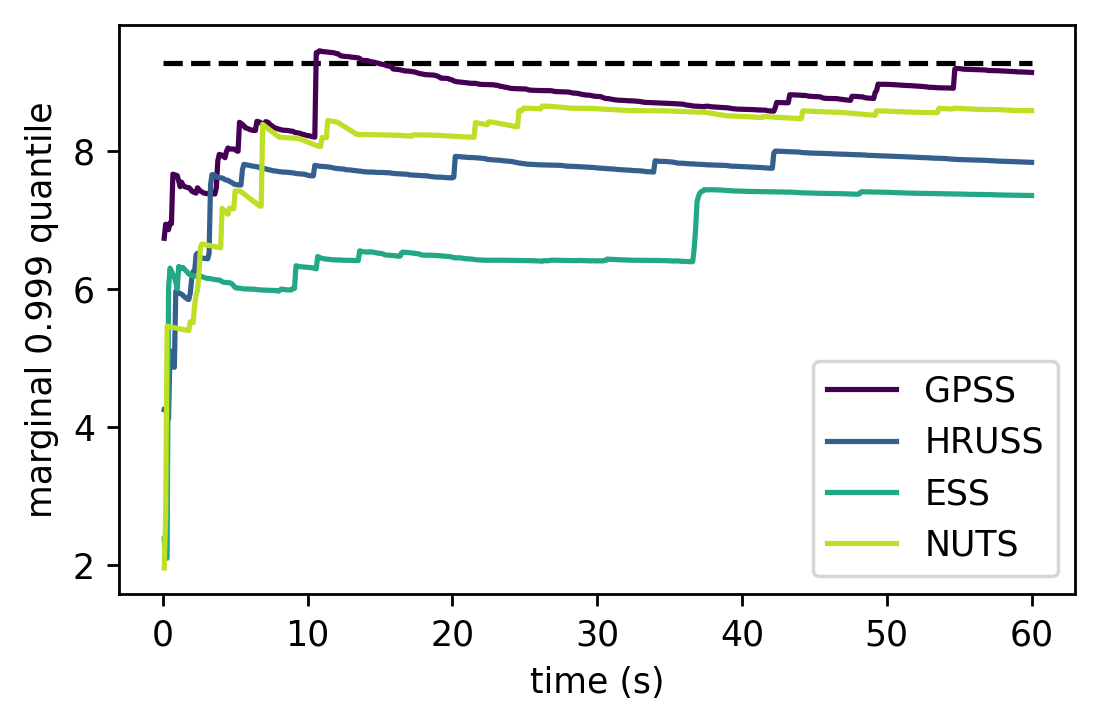

In [25]:
conv_plot(q2s, v2, "marginal {} quantile".format(q2), "q2_conv")

While we cannot make out much of a difference between the performances of GPSS, HRUSS and ESS for the target quantities mean and standard deviation, the corresponding plots for the two quantile targets suggest that GPSS has a sizable advantage over its competitors. Notably, NUTS' estimates remain poor throughout the run for all but the last quantity, see below for more insight into this.

In [26]:
plt.rcParams["axes.prop_cycle"] = default_cycler

In [27]:
def plot_histogram_and_marginal_and_radii(msamples, vals, snames, nbins=100, window=int(1e4), dpi=250, linewidth=None, filepath=None):
    nsam = len(snames)
    if linewidth == None:
        linewidth = min(1e3/window, 1.0)
    plt.figure(figsize=(10,2*nsam), dpi=dpi, constrained_layout=True)
    # left column: marginal trace plot (a window)
    for i in range(nsam):
        ax = plt.subplot(nsam, 3, 1 + 3 * i)
        ax.set_ylabel(snames[i], fontdict={'size': 10})
        ax.set_xlim(0,window)
        if i < nsam-1:
            ax.set_xticks([])
        else:
            #ax.set_xticks(np.arange(0,1e4+1,2e3), ["0", "2e3", "4e3", "6e3", "8e3", "1e4"])
            ax.set_xticks(np.arange(0,1e4,3e3))
        ax.set_ylim(-9,9)
        ax.set_yticks(range(-8,9,4))
        ax.plot(msamples[i][-window:], linewidth=linewidth)
    # middle column: histograms and target marginals
    x0s = np.linspace(-12, 12, 1000)
    for i in range(nsam):
        ax = plt.subplot(nsam, 3, 2 + 3 * i)
        ax.set_xlim((-12,12))
        if i < nsam-1:
            ax.set_xticks([])
        ax.set_ylim((0.0,0.2))
        ax.set_yticks([]) #(np.arange(0, 0.15, 0.02))
        ax.hist(msamples[i], bins=nbins, density=True)
        ax.plot(x0s, sts.norm.pdf(x0s, 0, 3), color="black")
    # right column: radii trace plot (a window)
    for i in range(nsam):
        ax = plt.subplot(nsam, 3, 3 + 3 * i)
        ax.set_xlim(0,window)
        if i < nsam-1:
            ax.set_xticks([])
        else:
            #ax.set_xticks(np.arange(0,1e4+1,2e3), ["0", "2e3", "4e3", "6e3", "8e3", "1e4"])
            ax.set_xticks(np.arange(0,1e4,3e3))
        ax.yaxis.tick_right()
        ax.plot(vals[i][-window:], linewidth=linewidth)
    if filepath != None:
        plt.savefig(filepath)
    plt.show()

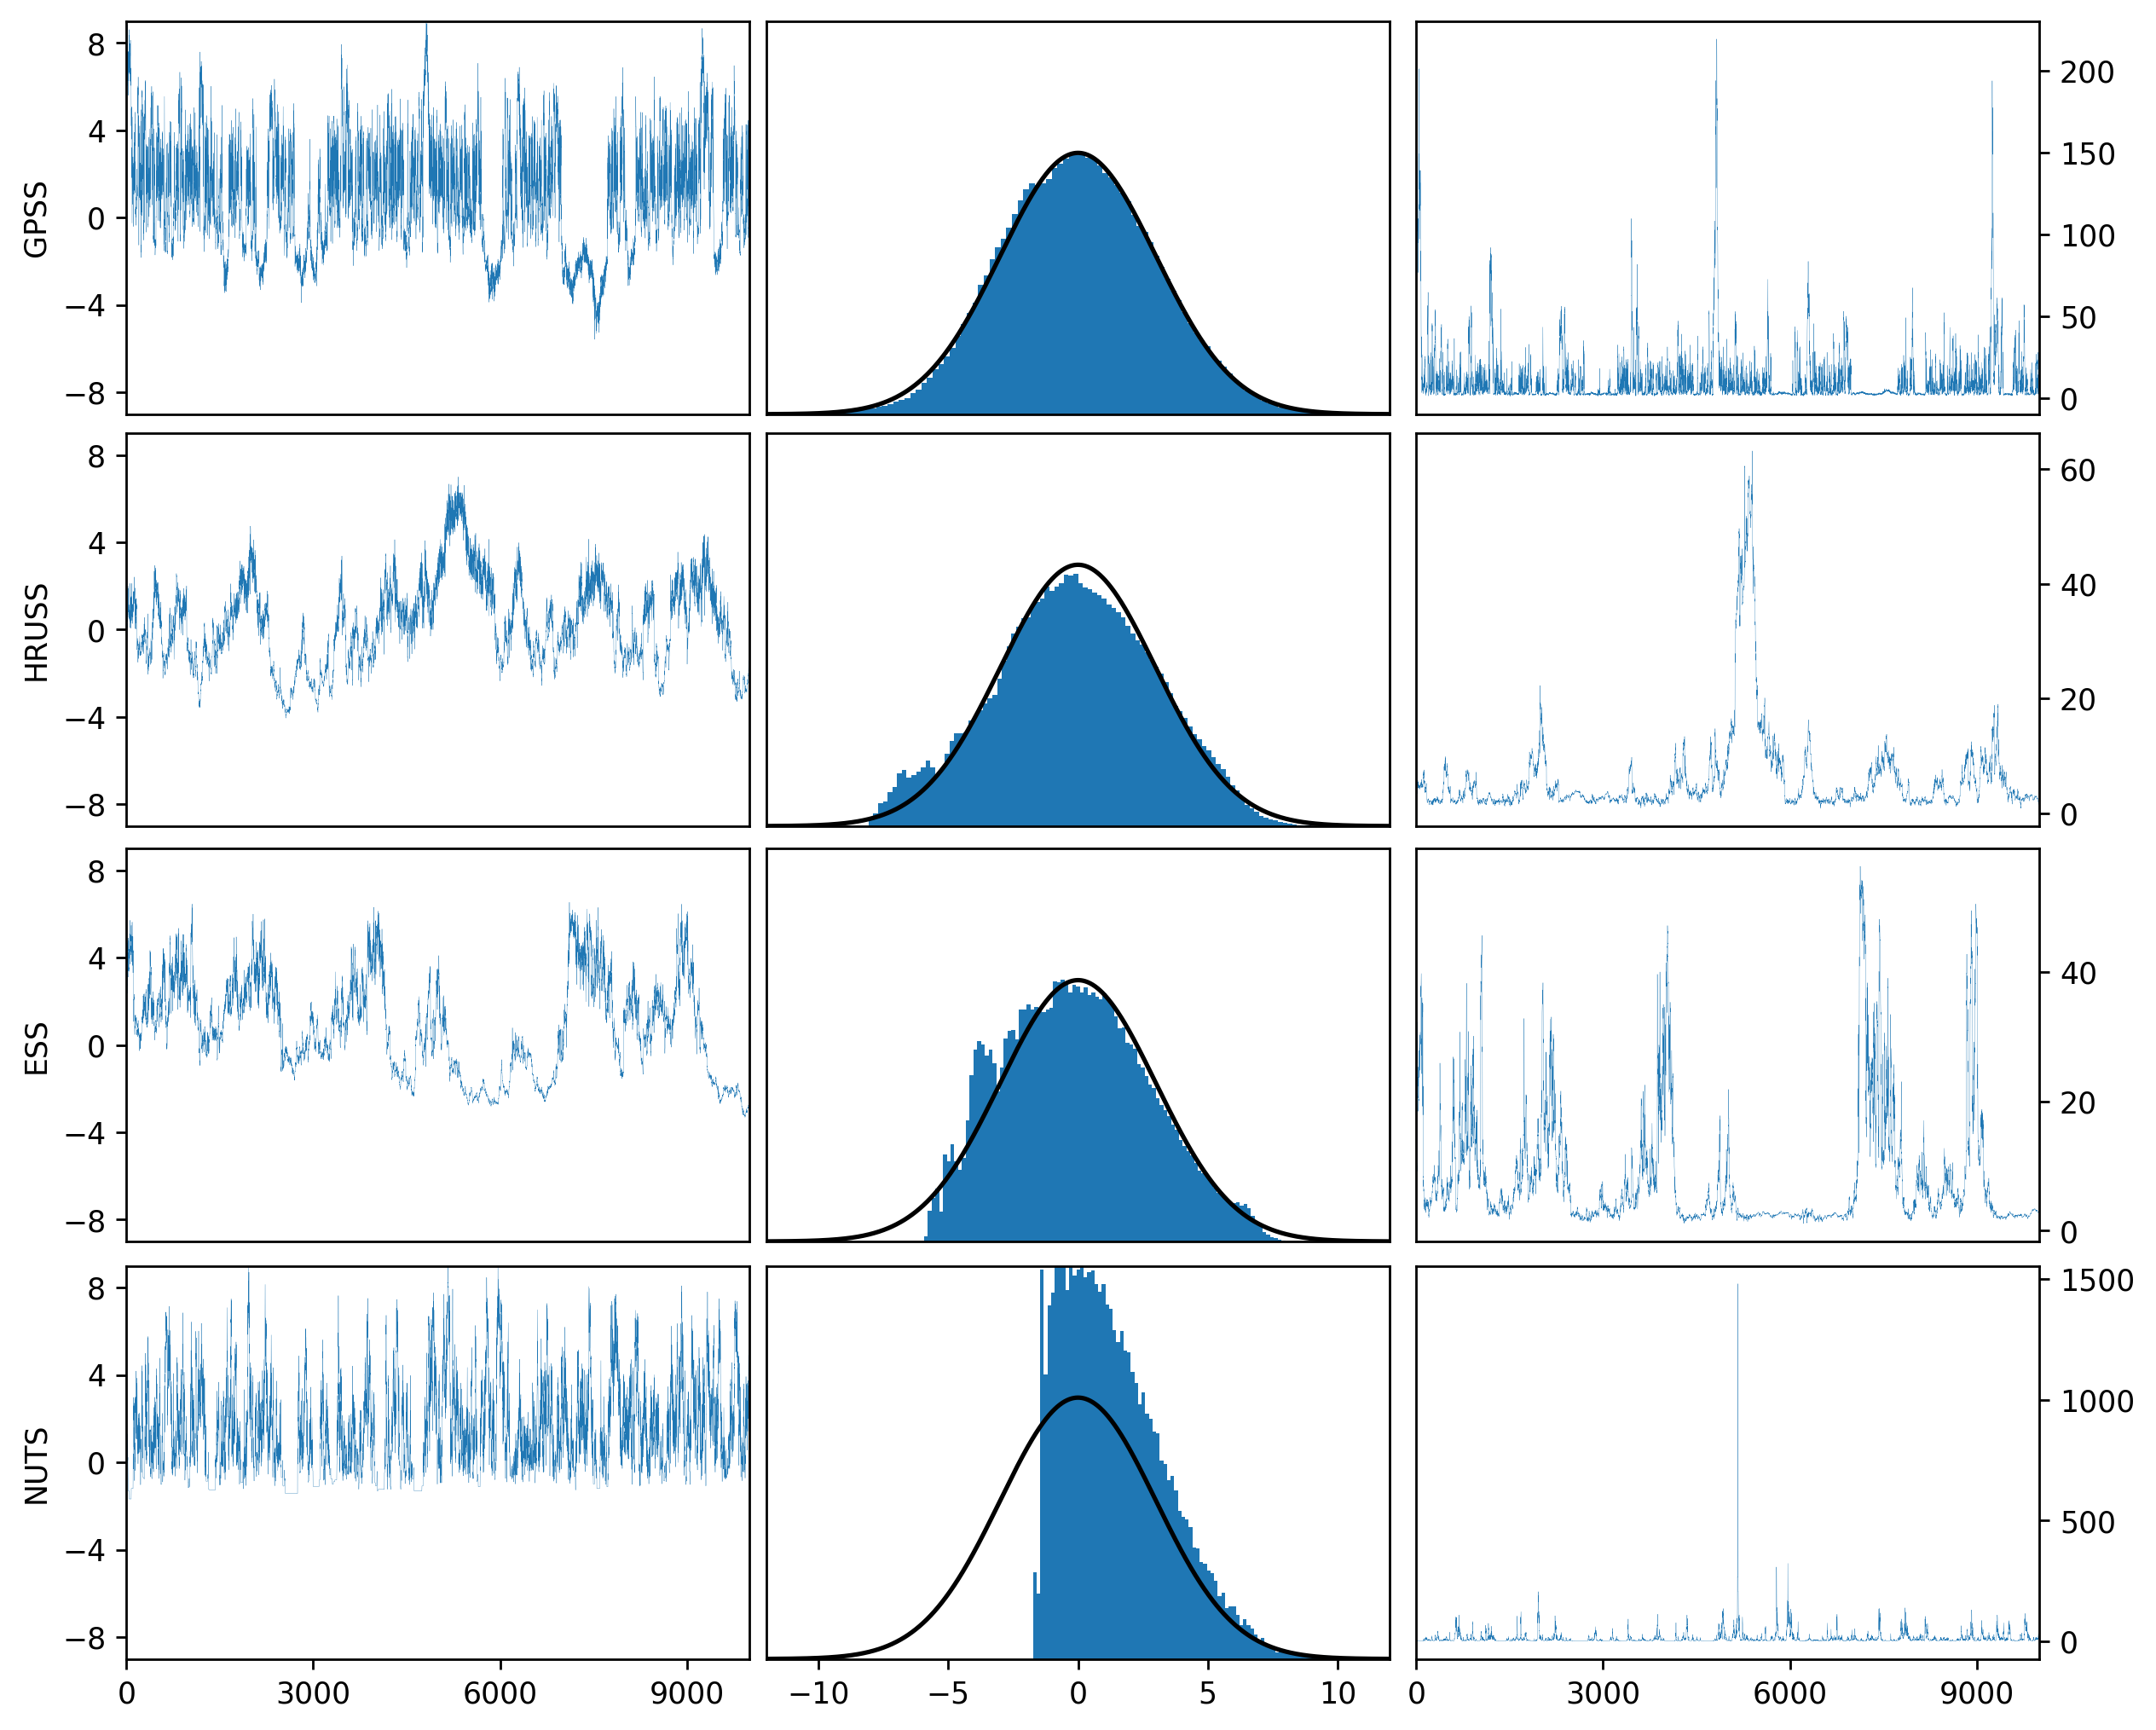

In [28]:
plot_histogram_and_marginal_and_radii(marginal_samples, radii, snames, filepath = path_prefix + "histograms_marginals_radii.png")

The middle column of the above plot shows that the three slice samplers all manage to recover the rough shape of the marginal density (namely, that of a bell curve), with GPSS reaching a signficantly higher accuracy than its competitors. NUTS on the other hand all but fails to enter the narrow part of the funnel, exploring only the wide part instead. This explains why it did such a poor job estimating the target quantities, even easy ones like the marginal mean. Without getting into too much detail on the inner workings of NUTS, the main issue is that it tries to adaptively choose a step size and then leave it fixed. As it was initialized in the wide part of the funnel, it only saw this wide region during the adaptation and correspondingly chose its step size large to suit its drawn-out nature. However, this made it near-incapable of entering and exploring the narrow part of the funnel, where far smaller step sizes are required.

The left column shows that even GPSS struggles with the transitions between narrow and wide part of the funnel, only moving far into the narrow part every few hundred iterations. Of course this is even more pronounced for the competitor methods.

Finally, the right column shows how well each sampler managed to explore the funnel's wide region, with GPSS characteristically taking trips far into the tails within just a few iterations, NUTS essentially doing the same thanks to its large step size, and HRUSS and ESS requiring hundreds or even thousands of iterations just to reach points of radii in the few dozens.